# 寻找标记基因

In [ ]:
from __future__ import annotations

import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.set_figure_params(dpi=80, facecolor="white")
sc.logging.print_header()

results_file = "write/pbmc3k.h5ad"

adata = sc.read_10x_mtx(
    "data/filtered_gene_bc_matrices/hg19/",  # the directory with the `.mtx` file
    var_names="gene_symbols",  # use gene symbols for the variable names (variables-axis index)
    cache=True,  # write a cache file for faster subsequent reading
)
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

sc.pp.filter_cells(adata, min_genes=200)  # this does nothing, in this specific case
sc.pp.filter_genes(adata, min_cells=3)

# annotate the group of mitochondrial genes as "mt"
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)

sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

fig, axs = plt.subplots(1, 2, figsize=(10, 4), layout="constrained")
sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt", show=False, ax=axs[0])
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts", show=False, ax=axs[1]);

adata = adata[
    (adata.obs.n_genes_by_counts < 2500) & (adata.obs.n_genes_by_counts > 200) & (adata.obs.pct_counts_mt < 5),
    :,
].copy()
adata.layers["counts"] = adata.X.copy()

sc.pp.normalize_total(adata, target_sum=1e4)

sc.pp.log1p(adata)


sc.pp.highly_variable_genes(
    adata,
    layer="counts",
    n_top_genes=2000,
    min_mean=0.0125,
    max_mean=3,
    min_disp=0.5,
    flavor="seurat_v3",
)

sc.pl.highly_variable_genes(adata)


adata.layers["scaled"] = adata.X.toarray()
sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"], layer="scaled")
sc.pp.scale(adata, max_value=10, layer="scaled")

# PCA
sc.pp.pca(adata, layer="scaled", svd_solver="arpack")
sc.pl.pca(adata, annotate_var_explained=True, color="CST3")
sc.pl.pca_variance_ratio(adata, n_pcs=20)
sc.pl.pca_loadings(adata, components=(1, 2), include_lowest=True)

# 计算邻近细胞
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

# Leiden聚类
sc.tl.leiden(
    adata,
    resolution=0.7,
    random_state=0,
    flavor="igraph",
    n_iterations=2,
    directed=False,
)

# PAGA
sc.tl.paga(adata)
# 必须sc.pl.paga，否则umap出错
sc.pl.paga(adata, plot=True)  # remove `plot=False` if you want to see the coarse-grained graph

# UMAP
sc.tl.umap(adata, init_pos='paga')
sc.tl.umap(adata)
sc.pl.umap(adata, color=["leiden", "CD14", "NKG7"])
adata

## sc.tl.rank_genes_groups(method="t-test")

现在对每个细胞亚群中的高差异基因进行排序评估。最简洁高效的方法当属t检验。

比较某一个分组与其他剩余组的差异。有多少组，比多少次。

```
adata.uns['rank_genes_groups'].keys()
dict_keys(['params', 'names', 'scores', 'pvals', 'pvals_adj', 'logfoldchanges'])
```

In [ ]:
sc.tl.rank_genes_groups(adata, "leiden", mask_var="highly_variable", method="t-test")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

## sc.tl.rank_genes_groups(method="wilcoxon")

威尔科克森秩和检验（曼-惠特尼U检验）的结果与之高度相似。在发表论文时我们建议采用后者，

具体可参考Soneson与Robinson的研究[2018]。若需更高统计功效，还可考虑MAST、limma、

DESeq2等差异分析工具，Python用户则可选用新兴的diffxpy。

In [ ]:
sc.tl.rank_genes_groups(adata, "leiden", mask_var="highly_variable", method="wilcoxon")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)
adata.write(results_file)

## sc.tl.rank_genes_groups(method="logreg")


替代方案：采用逻辑回归对基因进行排序。例如Ntranos等人[2019]便曾提出该方法。其核心差异在于——传统差异检验均采用单变量方法，

而本方案使用多变量建模。详见Clark等人[2014]的论述。

这些基因大多属于高表达基因范畴，但存在显著例外——例如CD8A分子（参见下方点阵图）。



In [ ]:
sc.tl.rank_genes_groups(adata, "leiden", mask_var="highly_variable", method="logreg", max_iter=1000)
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [ ]:
adata.uns["rank_genes_groups"]["names"]

## 差异基因表格

### 查看每组的差异基因

In [ ]:
# 读取 wilcox 检验的结果
adata = sc.read(results_file)

pd.DataFrame(adata.uns["rank_genes_groups"]["names"])


### 查看每组的差异基因以及打分

In [ ]:
result = adata.uns["rank_genes_groups"]
groups = result["names"].dtype.names
pd.DataFrame({f"{group}_{key[:1]}": result[key][group] for group in groups for key in ["names", "pvals"]}).head(5)

### 比较单个聚类

In [ ]:
sc.tl.rank_genes_groups(
    adata,
    "leiden",
    mask_var="highly_variable",
    groups=["0"],
    reference="1",
    method="wilcoxon",
)
sc.pl.rank_genes_groups(adata, groups=["0"], n_genes=20)

## 查看特定组的细节

In [ ]:
sc.pl.rank_genes_groups_violin(adata, groups="0", n_genes=8)

## 查看特定组与其他组的差异

In [ ]:
adata = sc.read(results_file)
sc.pl.rank_genes_groups_violin(adata, groups="0", n_genes=8)

## 小提琴图在组间比较特定基因

小提琴的每个点，是一个细胞的变量，变量要么来源于.var_names，要么来源于.obs。即要么是基因表达量，要么是细胞的注释信息。

In [ ]:
sc.pl.violin(adata, ["CST3", "NKG7", "PPBP"], groupby="leiden")

## 手工注释

In [ ]:
new_cluster_names = [
    "CD4 T",
    "B",
    "CD14+ Monocytes",
    "NK",
    "CD8 T",
    "FCGR3A+ Monocytes",
    "Dendritic",
    "Megakaryocytes",
]
adata.rename_categories("leiden", new_cluster_names)

sc.pl.umap(adata, color="leiden", legend_loc="on data", title="", frameon=False, save=".pdf")

## 标记基因在各组之间的点图（重点理解）

In [ ]:
marker_genes = [
    *["IL7R", "CD79A", "MS4A1", "CD8A", "CD8B", "LYZ", "CD14"],
    *["LGALS3", "S100A8", "GNLY", "NKG7", "KLRB1"],
    *["FCGR3A", "MS4A7", "FCER1A", "CST3", "PPBP"],
]

### sc.pl.dotplot()

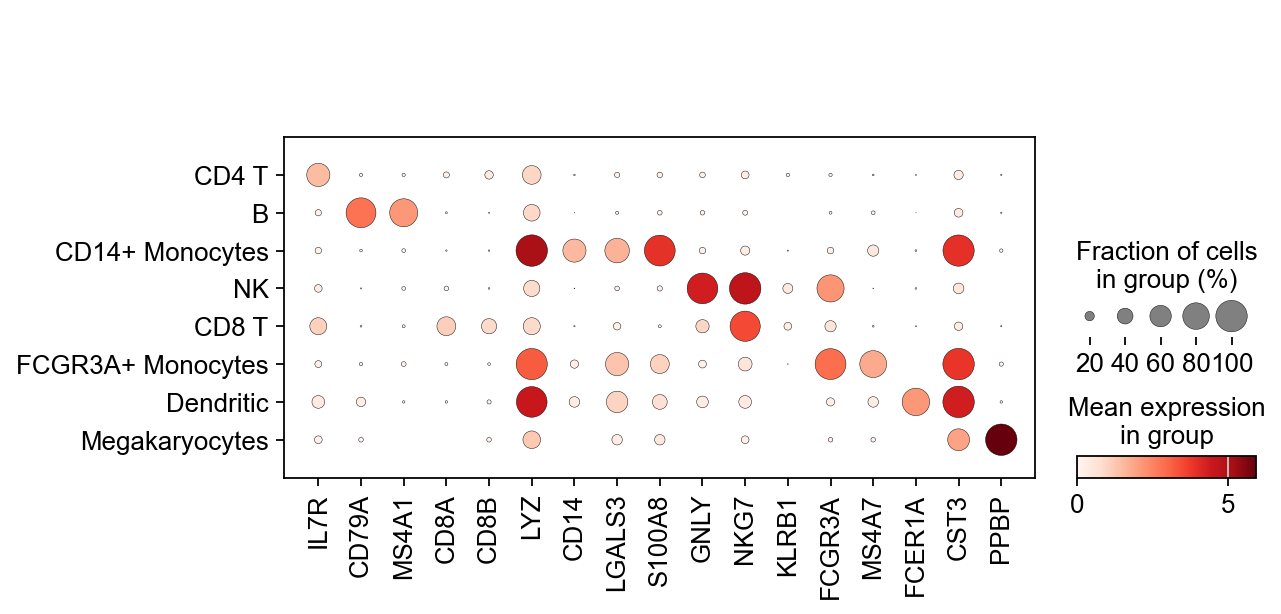

In [14]:
sc.pl.dotplot(adata, marker_genes, groupby="leiden")

### sc.pl.stacked_violin()

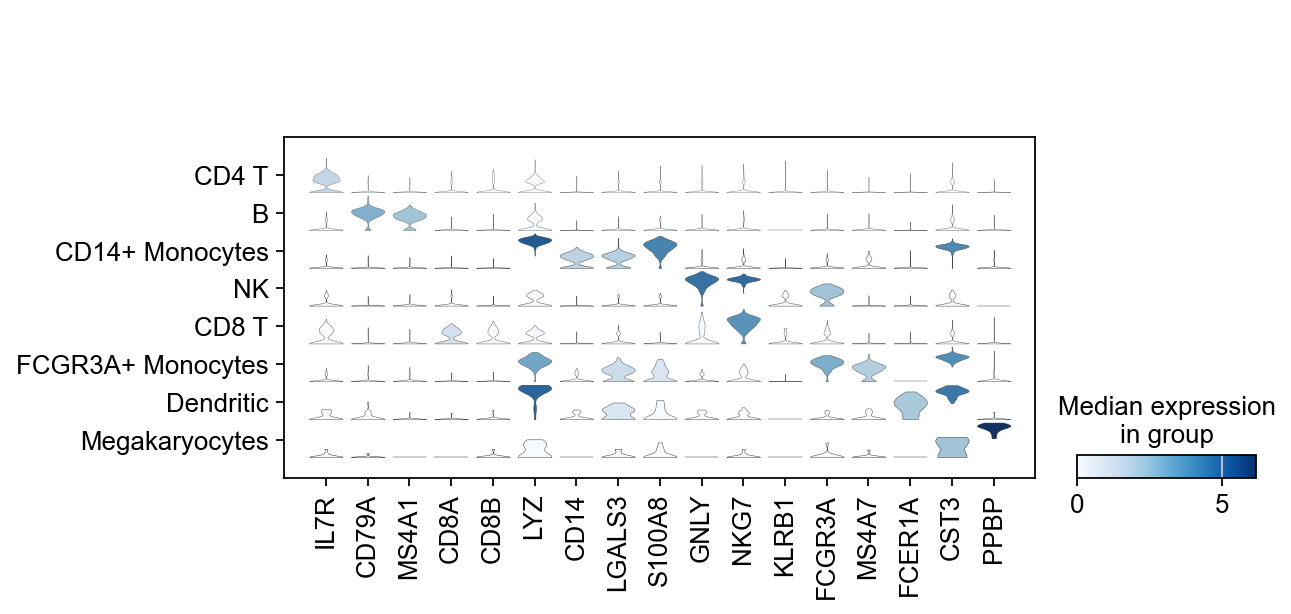

In [15]:
sc.pl.stacked_violin(adata, marker_genes, groupby="leiden")

# 教程结束

In [16]:
adata.write(results_file, compression="gzip")

# 源码解析

## sc.tl.rand_genes_groups()源码

In [ ]:
def rank_genes_groups(  # noqa: PLR0912, PLR0913, PLR0915
    adata: AnnData,
    groupby: str,
    *,
    mask_var: NDArray[np.bool_] | str | None = None,
    method: _Method | None = None,
):
    """Rank genes for characterizing groups.
    
    """
    # 默认检验方法
    if method is None:
        method = "t-test"

    # 只能是两种校正方法
    avail_corr = {"benjamini-hochberg", "bonferroni"}
    if corr_method not in avail_corr:
        msg = f"Correction method must be one of {avail_corr}."
        raise ValueError(msg)

    # 默认结果保存在 adata.uns['rank_genes_groups'] 字典当中
    # 每次运行，都会覆盖之前的结果，因此可以多次运行
    if key_added is None:
        key_added = "rank_genes_groups"
    adata.uns[key_added] = {}
    adata.uns[key_added]["params"] = dict(
        groupby=groupby,
        reference=reference,
        method=method,
        use_raw=use_raw,
        layer=layer,
        corr_method=corr_method,
    )

    # 检验
    test_obj = _RankGenes(
        adata,
        groups_order,
        groupby,
        mask_var=mask_var,
        reference=reference,
        use_raw=use_raw,
        layer=layer,
        comp_pts=pts,
    )

    # 检验
    test_obj.compute_statistics(
        method,
        corr_method=corr_method,
        n_genes_user=n_genes_user,
        rankby_abs=rankby_abs,
        tie_correct=tie_correct,
        **kwds,
    )
    
    dtypes = {
        "names": "O",
        "scores": "float32",
        "logfoldchanges": "float32",
        "pvals": "float64",
        "pvals_adj": "float64",
    }

    for col in test_obj.stats.columns.levels[0]:
        adata.uns[key_added][col] = test_obj.stats[col].to_records(
            index=False, column_dtypes=dtypes[col]
        )

    logg.info(
        "    finished",
        time=start,
        deep=(
            f"added to `.uns[{key_added!r}]`\n"
            "    'names', sorted np.recarray to be indexed by group ids\n"
            "    'scores', sorted np.recarray to be indexed by group ids\n"
            + (
                "    'logfoldchanges', sorted np.recarray to be indexed by group ids\n"
                "    'pvals', sorted np.recarray to be indexed by group ids\n"
                "    'pvals_adj', sorted np.recarray to be indexed by group ids"
                if method in {"t-test", "t-test_overestim_var", "wilcoxon"}
                else ""
            )
        ),
    )

    """
    adata.uns['rank_genes_groups'].keys()
    dict_keys(['params', 'names', 'scores', 'pvals', 'pvals_adj', 'logfoldchanges'])
    """
    
    return adata if copy else None


## sc.pl.dotplot()

In [ ]:
def dotplot(  # noqa: PLR0913
    adata: AnnData,
    var_names: _VarNames | Mapping[str, _VarNames],
    groupby: str | Sequence[str],
    *,
    use_raw: bool | None = None,
    log: bool = False,
    num_categories: int = 7,
    categories_order: Sequence[str] | None = None,
    expression_cutoff: float = 0.0,
    mean_only_expressed: bool = False,
    standard_scale: Literal["var", "group"] | None = None,
    title: str | None = None,
    colorbar_title: str | None = DotPlot.DEFAULT_COLOR_LEGEND_TITLE,
    size_title: str | None = DotPlot.DEFAULT_SIZE_LEGEND_TITLE,
    figsize: tuple[float, float] | None = None,
    dendrogram: bool | str = False,
    gene_symbols: str | None = None,
    var_group_positions: Sequence[tuple[int, int]] | None = None,
    var_group_labels: Sequence[str] | None = None,
    var_group_rotation: float | None = None,
    layer: str | None = None,
    swap_axes: bool | None = False,
    dot_color_df: pd.DataFrame | None = None,
    show: bool | None = None,
    save: str | bool | None = None,
    ax: _AxesSubplot | None = None,
    return_fig: bool | None = False,
    vmin: float | None = None,
    vmax: float | None = None,
    vcenter: float | None = None,
    norm: Normalize | None = None,
    # Style parameters
    cmap: Colormap | str | None = DotPlot.DEFAULT_COLORMAP,
    dot_max: float | None = DotPlot.DEFAULT_DOT_MAX,
    dot_min: float | None = DotPlot.DEFAULT_DOT_MIN,
    smallest_dot: float = DotPlot.DEFAULT_SMALLEST_DOT,
    **kwds,
) -> DotPlot | dict | None:
    # backwards compatibility: previous version of dotplot used `color_map`
    # instead of `cmap`
    cmap = kwds.pop("color_map", cmap)

    dp = DotPlot(
        adata,
        var_names,
        groupby,
        use_raw=use_raw,
        log=log,
        num_categories=num_categories,
        categories_order=categories_order,
        expression_cutoff=expression_cutoff,
        mean_only_expressed=mean_only_expressed,
        standard_scale=standard_scale,
        title=title,
        figsize=figsize,
        gene_symbols=gene_symbols,
        var_group_positions=var_group_positions,
        var_group_labels=var_group_labels,
        var_group_rotation=var_group_rotation,
        layer=layer,
        dot_color_df=dot_color_df,
        ax=ax,
        vmin=vmin,
        vmax=vmax,
        vcenter=vcenter,
        norm=norm,
        **kwds,
    )

    if dendrogram:
        dp.add_dendrogram(dendrogram_key=_dk(dendrogram))
    if swap_axes:
        dp.swap_axes()

    dp = dp.style(
        cmap=cmap,
        dot_max=dot_max,
        dot_min=dot_min,
        smallest_dot=smallest_dot,
        dot_edge_lw=kwds.pop("linewidth", _empty),
    ).legend(colorbar_title=colorbar_title, size_title=size_title)

    if return_fig:
        return dp
    else:
        dp.make_figure()
        savefig_or_show(DotPlot.DEFAULT_SAVE_PREFIX, show=show, save=save)
        show = settings.autoshow if show is None else show
        if not show:
            return dp.get_axes()

### 提取数据框 get.obs_df()

先提取基因表达量，再提取obs表变量。

In [ ]:
"""
通过 get.obs_df() 提取基因的表达量和leiden分组
仅传入 leiden 和 基因名称
(Pdb) p layer,use_raw,gene_symbols
(None, False, None)

keys = list(groupby) + list(np.unique(var_names))
(Pdb) p keys
# ['leiden', np.str_('CD14'), np.str_('CD79A'), np.str_('CD8A'), np.str_('CD8B'), np.str_('CST3'), np.str_('FCER1A'), np.str_('FCGR3A'), np.str_('GNLY'), np.str_('IL7R'), np.str_('KLRB1'), np.str_('LGALS3'), np.str_('LYZ'), np.str_('MS4A1'), np.str_('MS4A7'), np.str_('NKG7'), np.str_('PPBP'), np.str_('S100A8')]
"""
obs_tidy = get.obs_df(
    adata, keys=keys, layer=layer, use_raw=use_raw, gene_symbols=gene_symbols
）

"""
先创建一个 adata.obs_names 为索引的空数据框
(Pdb) df
Empty DataFrame
Columns: []
Index: [AAACATACAACCAC-1, AAACATTGAGCTAC-1, AAACATTGATCAGC-1, AAACCGTGCTTCCG-1, AAACCGTGTATGCG-1, AAACGCACTGGTAC-1, AAACGCTGACCAGT-1, AAACGCTGGTTCTT-1, AAACGCTGTAGCCA-1, AAACGCTGTTTCTG-1, AAACTTGAAAAACG-1, AAACTTGATCCAGA-1, AAAGAGACGAGATA-1, AAAGAGACGCGAGA-1, AAAGAGACGGACTT-1, AAAGAGACGGCATT-1, AAAGCAGATATCGG-1, AAAGCCTGTATGCG-1, AAAGGCCTGTCTAG-1, AAAGTTTGATCACG-1, AAAGTTTGGGGTGA-1, AAAGTTTGTAGAGA-1, AAAGTTTGTAGCGT-1, AAATCAACAATGCC-1, AAATCAACACCAGT-1, AAATCAACCAGGAG-1, AAATCAACCCTATT-1, AAATCAACGGAAGC-1, AAATCAACTCGCAA-1, AAATCATGACCACA-1, AAATCCCTCCACAA-1, AAATCCCTGCTATG-1, AAATGTTGAACGAA-1, AAATGTTGCCACAA-1, AAATGTTGTGGCAT-1, AAATTCGAAGGTTC-1, AAATTCGAATCACG-1, AAATTCGAGCTGAT-1, AAATTCGAGGAGTG-1, AAATTCGATTCTCA-1, AAATTGACACGACT-1, AAATTGACTCGCTC-1, AACAAACTCATTTC-1, AACAAACTTTCGTT-1, AACAATACGACGAG-1, AACACGTGCAGAGG-1, AACACGTGGAAAGT-1, AACACGTGGAACCT-1, AACACGTGGCTACA-1, AACACGTGTACGAC-1, AACAGCACAAGAGT-1, AACATTGATGGGAG-1, AACCAGTGATACCG-1, AACCCAGATCGCTC-1, AACCGATGCTCCCA-1, AACCGATGGTCATG-1, AACCGATGTTCTAC-1, AACCGCCTAGCGTT-1, AACCGCCTCTACGA-1, AACCTACTGTGAGG-1, AACCTACTGTGTTG-1, AACCTTACGAGACG-1, AACCTTACGCGAGA-1, AACCTTACTAACGC-1, AACCTTTGGACGGA-1, AACCTTTGTACGCA-1, AACGCAACAAGTAG-1, AACGCATGACCCAA-1, AACGCATGCCTTCG-1, AACGCATGTACTTC-1, AACGCCCTCGGGAA-1, AACGCCCTCGTACA-1, AACGCCCTGGCATT-1, AACGTCGAGTATCG-1, AACGTGTGAAAGCA-1, AACGTGTGGCGGAA-1, AACGTGTGTCCAAG-1, AACGTGTGTGCTTT-1, AACTACCTTAGAGA-1, AACTCACTCAAGCT-1, AACTCACTTGGAGG-1, AACTCGGAAAGTGA-1, AACTCGGAAGGTCT-1, AACTCTTGCAGGAG-1, AACTGTCTCCCTTG-1, AACTTGCTACGCTA-1, AACTTGCTGGGACA-1, AAGAACGAGTGTTG-1, AAGAAGACGTAGGG-1, AAGACAGAAGTCTG-1, AAGACAGAGGATCT-1, AAGACAGATTACCT-1, AAGAGATGGGTAGG-1, AAGATGGAAAACAG-1, AAGATGGAGAACTC-1, AAGATGGAGATAAG-1, AAGATTACAACCTG-1, AAGATTACAGATCC-1, AAGATTACCCGTTC-1, AAGATTACCGCCTT-1, ...]

[2638 rows x 0 columns]
"""

"""
提取基因表达量
(Pdb) df
                      CD14     CD79A      CD8A      CD8B      CST3    FCER1A    FCGR3A      GNLY      IL7R  KLRB1    LGALS3       LYZ     MS4A1     MS4A7      NKG7      PPBP    S100A8
AAACATACAACCAC-1  0.000000  0.000000  1.635873  2.226555  0.000000  0.000000  0.000000  0.000000  2.595391    0.0  0.000000  1.635873  0.000000  0.000000  0.000000  0.000000  0.000000
AAACATTGAGCTAC-1  0.000000  1.962726  0.000000  0.000000  1.111715  0.000000  0.000000  0.000000  1.625141    0.0  0.000000  1.962726  2.583047  0.000000  1.111715  0.000000  0.000000
AAACATTGATCAGC-1  0.000000  0.000000  0.000000  0.000000  1.429744  0.000000  0.000000  1.429744  1.429744    0.0  0.000000  1.995416  0.000000  0.000000  0.000000  0.000000  0.000000
AAACCGTGCTTCCG-1  0.000000  0.000000  0.000000  0.000000  4.435152  0.000000  1.566387  0.000000  0.000000    0.0  0.000000  4.521174  0.000000  2.515108  1.566387  1.566387  2.515108
AAACCGTGTATGCG-1  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  3.453545  0.000000    0.0  0.000000  0.000000  0.000000  0.000000  4.729553  0.000000  0.000000
...                    ...       ...       ...       ...       ...       ...       ...       ...       ...    ...       ...       ...       ...       ...       ...       ...       ...
TTTCGAACTCTCAT-1  1.914275  0.000000  0.000000  0.000000  4.406088  1.358668  0.000000  0.000000  0.000000    0.0  2.269341  5.225879  0.000000  0.000000  1.358668  0.000000  4.212027
TTTCTACTGAGGCA-1  0.000000  3.579436  0.000000  0.000000  1.362115  0.000000  0.000000  0.000000  1.362115    0.0  0.000000  0.000000  1.362115  0.000000  0.000000  0.000000  0.000000
TTTCTACTTCCTCG-1  0.000000  3.423976  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000    0.0  0.000000  0.000000  1.937048  0.000000  0.000000  0.000000  0.000000
TTTGCATGAGAGGC-1  0.000000  4.089473  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000    0.0  0.000000  0.000000  3.692347  0.000000  0.000000  0.000000  0.000000
TTTGCATGCCTCAC-1  0.000000  0.000000  0.000000  0.000000  1.798457  0.000000  0.000000  0.000000  0.000000    0.0  0.000000  1.798457  0.000000  0.000000  0.000000  0.000000  0.000000

[2638 rows x 17 columns]
"""

"""
提取leiden变量
df = pd.concat([df, adata.obs[obs_cols]], axis=1)

(Pdb) df
                      CD14     CD79A      CD8A      CD8B      CST3    FCER1A    FCGR3A      GNLY      IL7R  KLRB1    LGALS3       LYZ     MS4A1     MS4A7      NKG7      PPBP    S100A8           leiden
AAACATACAACCAC-1  0.000000  0.000000  1.635873  2.226555  0.000000  0.000000  0.000000  0.000000  2.595391    0.0  0.000000  1.635873  0.000000  0.000000  0.000000  0.000000  0.000000            CD4 T
AAACATTGAGCTAC-1  0.000000  1.962726  0.000000  0.000000  1.111715  0.000000  0.000000  0.000000  1.625141    0.0  0.000000  1.962726  2.583047  0.000000  1.111715  0.000000  0.000000                B
AAACATTGATCAGC-1  0.000000  0.000000  0.000000  0.000000  1.429744  0.000000  0.000000  1.429744  1.429744    0.0  0.000000  1.995416  0.000000  0.000000  0.000000  0.000000  0.000000            CD4 T
AAACCGTGCTTCCG-1  0.000000  0.000000  0.000000  0.000000  4.435152  0.000000  1.566387  0.000000  0.000000    0.0  0.000000  4.521174  0.000000  2.515108  1.566387  1.566387  2.515108  CD14+ Monocytes
AAACCGTGTATGCG-1  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  3.453545  0.000000    0.0  0.000000  0.000000  0.000000  0.000000  4.729553  0.000000  0.000000               NK
...                    ...       ...       ...       ...       ...       ...       ...       ...       ...    ...       ...       ...       ...       ...       ...       ...       ...              ...
TTTCGAACTCTCAT-1  1.914275  0.000000  0.000000  0.000000  4.406088  1.358668  0.000000  0.000000  0.000000    0.0  2.269341  5.225879  0.000000  0.000000  1.358668  0.000000  4.212027  CD14+ Monocytes
TTTCTACTGAGGCA-1  0.000000  3.579436  0.000000  0.000000  1.362115  0.000000  0.000000  0.000000  1.362115    0.0  0.000000  0.000000  1.362115  0.000000  0.000000  0.000000  0.000000                B
TTTCTACTTCCTCG-1  0.000000  3.423976  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000    0.0  0.000000  0.000000  1.937048  0.000000  0.000000  0.000000  0.000000                B
TTTGCATGAGAGGC-1  0.000000  4.089473  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000    0.0  0.000000  0.000000  3.692347  0.000000  0.000000  0.000000  0.000000                B
TTTGCATGCCTCAC-1  0.000000  0.000000  0.000000  0.000000  1.798457  0.000000  0.000000  0.000000  0.000000    0.0  0.000000  1.798457  0.000000  0.000000  0.000000  0.000000  0.000000            CD4 T

[2638 rows x 18 columns]
"""

"""
调整变量的顺序
(Pdb) p keys
['leiden', np.str_('CD14'), np.str_('CD79A'), np.str_('CD8A'), np.str_('CD8B'), np.str_('CST3'), np.str_('FCER1A'), np.str_('FCGR3A'), np.str_('GNLY'), np.str_('IL7R'), np.str_('KLRB1'), np.str_('LGALS3'), np.str_('LYZ'), np.str_('MS4A1'), np.str_('MS4A7'), np.str_('NKG7'), np.str_('PPBP'), np.str_('S100A8')]
if keys:
    df = df[keys]

(Pdb) df
                           leiden      CD14     CD79A      CD8A      CD8B      CST3    FCER1A    FCGR3A      GNLY      IL7R  KLRB1    LGALS3       LYZ     MS4A1     MS4A7      NKG7      PPBP    S100A8
AAACATACAACCAC-1            CD4 T  0.000000  0.000000  1.635873  2.226555  0.000000  0.000000  0.000000  0.000000  2.595391    0.0  0.000000  1.635873  0.000000  0.000000  0.000000  0.000000  0.000000
AAACATTGAGCTAC-1                B  0.000000  1.962726  0.000000  0.000000  1.111715  0.000000  0.000000  0.000000  1.625141    0.0  0.000000  1.962726  2.583047  0.000000  1.111715  0.000000  0.000000
AAACATTGATCAGC-1            CD4 T  0.000000  0.000000  0.000000  0.000000  1.429744  0.000000  0.000000  1.429744  1.429744    0.0  0.000000  1.995416  0.000000  0.000000  0.000000  0.000000  0.000000
AAACCGTGCTTCCG-1  CD14+ Monocytes  0.000000  0.000000  0.000000  0.000000  4.435152  0.000000  1.566387  0.000000  0.000000    0.0  0.000000  4.521174  0.000000  2.515108  1.566387  1.566387  2.515108
AAACCGTGTATGCG-1               NK  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  3.453545  0.000000    0.0  0.000000  0.000000  0.000000  0.000000  4.729553  0.000000  0.000000
...                           ...       ...       ...       ...       ...       ...       ...       ...       ...       ...    ...       ...       ...       ...       ...       ...       ...       ...
TTTCGAACTCTCAT-1  CD14+ Monocytes  1.914275  0.000000  0.000000  0.000000  4.406088  1.358668  0.000000  0.000000  0.000000    0.0  2.269341  5.225879  0.000000  0.000000  1.358668  0.000000  4.212027
TTTCTACTGAGGCA-1                B  0.000000  3.579436  0.000000  0.000000  1.362115  0.000000  0.000000  0.000000  1.362115    0.0  0.000000  0.000000  1.362115  0.000000  0.000000  0.000000  0.000000
TTTCTACTTCCTCG-1                B  0.000000  3.423976  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000    0.0  0.000000  0.000000  1.937048  0.000000  0.000000  0.000000  0.000000
TTTGCATGAGAGGC-1                B  0.000000  4.089473  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000    0.0  0.000000  0.000000  3.692347  0.000000  0.000000  0.000000  0.000000
TTTGCATGCCTCAC-1            CD4 T  0.000000  0.000000  0.000000  0.000000  1.798457  0.000000  0.000000  0.000000  0.000000    0.0  0.000000  1.798457  0.000000  0.000000  0.000000  0.000000  0.000000

[2638 rows x 18 columns]
"""

# ---------------------------------------
def _prepare_dataframe():
    categorical = obs_tidy[groupby[0]].astype("category")
    """
    groupby[0] = 'leiden'
    (Pdb) type(categorical)
    <class 'pandas.core.series.Series'>

    将 obs_tidy 数据框中的 leiden 列取出来，制作成分类变量，然后设置为 obs_tidy 的索引，替换原来的细胞索引。
    数据框中只保留基因列，分组的leiden设置成索引。
    """
    obs_tidy = obs_tidy[var_names].set_index(categorical)
    
    """
    (Pdb) obs_tidy
                     IL7R     CD79A     MS4A1      CD8A      CD8B       LYZ      CD14    LGALS3    S100A8      GNLY      NKG7  KLRB1    FCGR3A     MS4A7    FCER1A      CST3      PPBP
    leiden
    CD4 T            2.595391  0.000000  0.000000  1.635873  2.226555  1.635873  0.000000  0.000000  0.000000  0.000000  0.000000    0.0  0.000000  0.000000  0.000000  0.000000  0.000000
    B                1.625141  1.962726  2.583047  0.000000  0.000000  1.962726  0.000000  0.000000  0.000000  0.000000  1.111715    0.0  0.000000  0.000000  0.000000  1.111715  0.000000
    CD4 T            1.429744  0.000000  0.000000  0.000000  0.000000  1.995416  0.000000  0.000000  0.000000  1.429744  0.000000    0.0  0.000000  0.000000  0.000000  1.429744  0.000000
    CD14+ Monocytes  0.000000  0.000000  0.000000  0.000000  0.000000  4.521174  0.000000  0.000000  2.515108  0.000000  1.566387    0.0  1.566387  2.515108  0.000000  4.435152  1.566387
    NK               0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  3.453545  4.729553    0.0  0.000000  0.000000  0.000000  0.000000  0.000000
    ...                   ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...    ...       ...       ...       ...       ...       ...
    CD14+ Monocytes  0.000000  0.000000  0.000000  0.000000  0.000000  5.225879  1.914275  2.269341  4.212027  0.000000  1.358668    0.0  0.000000  0.000000  1.358668  4.406088  0.000000
    B                1.362115  3.579436  1.362115  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000    0.0  0.000000  0.000000  0.000000  1.362115  0.000000
    B                0.000000  3.423976  1.937048  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000    0.0  0.000000  0.000000  0.000000  0.000000  0.000000
    B                0.000000  4.089473  3.692347  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000    0.0  0.000000  0.000000  0.000000  0.000000  0.000000
    CD4 T            0.000000  0.000000  0.000000  0.000000  0.000000  1.798457  0.000000  0.000000  0.000000  0.000000  0.000000    0.0  0.000000  0.000000  0.000000  1.798457  0.000000

    [2638 rows x 17 columns]
    """
    

### 计算绘图数据

In [ ]:
Class DotPlot:
    def __init__():
        # 通过 BasePlot 已经获取了基因的leiden的数据信息。
        # 此时列是基因，索引是leiden分组。
        BasePlot.__init__()

        # 表达值是 X 中存储的标准化了的值，可以与直接提取的对比
        """
        (Pdb) self.obs_tidy
                            IL7R     CD79A     MS4A1      CD8A      CD8B       LYZ      CD14    LGALS3    S100A8      GNLY      NKG7  KLRB1    FCGR3A     MS4A7    FCER1A      CST3      PPBP
        leiden
        CD4 T            2.595391  0.000000  0.000000  1.635873  2.226555  1.635873  0.000000  0.000000  0.000000  0.000000  0.000000    0.0  0.000000  0.000000  0.000000  0.000000  0.000000
        B                1.625141  1.962726  2.583047  0.000000  0.000000  1.962726  0.000000  0.000000  0.000000  0.000000  1.111715    0.0  0.000000  0.000000  0.000000  1.111715  0.000000
        CD4 T            1.429744  0.000000  0.000000  0.000000  0.000000  1.995416  0.000000  0.000000  0.000000  1.429744  0.000000    0.0  0.000000  0.000000  0.000000  1.429744  0.000000
        CD14+ Monocytes  0.000000  0.000000  0.000000  0.000000  0.000000  4.521174  0.000000  0.000000  2.515108  0.000000  1.566387    0.0  1.566387  2.515108  0.000000  4.435152  1.566387
        NK               0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  3.453545  4.729553    0.0  0.000000  0.000000  0.000000  0.000000  0.000000
        ...                   ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...    ...       ...       ...       ...       ...       ...
        CD14+ Monocytes  0.000000  0.000000  0.000000  0.000000  0.000000  5.225879  1.914275  2.269341  4.212027  0.000000  1.358668    0.0  0.000000  0.000000  1.358668  4.406088  0.000000
        B                1.362115  3.579436  1.362115  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000    0.0  0.000000  0.000000  0.000000  1.362115  0.000000
        B                0.000000  3.423976  1.937048  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000    0.0  0.000000  0.000000  0.000000  0.000000  0.000000
        B                0.000000  4.089473  3.692347  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000    0.0  0.000000  0.000000  0.000000  0.000000  0.000000
        CD4 T            0.000000  0.000000  0.000000  0.000000  0.000000  1.798457  0.000000  0.000000  0.000000  0.000000  0.000000    0.0  0.000000  0.000000  0.000000  1.798457  0.000000

        [2638 rows x 17 columns]
        """

        # 直接提取的值
        """
        (Pdb) adata[:, var_names].to_df()
                            IL7R     CD79A     MS4A1      CD8A      CD8B       LYZ      CD14    LGALS3    S100A8      GNLY      NKG7  KLRB1    FCGR3A     MS4A7    FCER1A      CST3      PPBP
        AAACATACAACCAC-1  2.595391  0.000000  0.000000  1.635873  2.226555  1.635873  0.000000  0.000000  0.000000  0.000000  0.000000    0.0  0.000000  0.000000  0.000000  0.000000  0.000000
        AAACATTGAGCTAC-1  1.625141  1.962726  2.583047  0.000000  0.000000  1.962726  0.000000  0.000000  0.000000  0.000000  1.111715    0.0  0.000000  0.000000  0.000000  1.111715  0.000000
        AAACATTGATCAGC-1  1.429744  0.000000  0.000000  0.000000  0.000000  1.995416  0.000000  0.000000  0.000000  1.429744  0.000000    0.0  0.000000  0.000000  0.000000  1.429744  0.000000
        AAACCGTGCTTCCG-1  0.000000  0.000000  0.000000  0.000000  0.000000  4.521174  0.000000  0.000000  2.515108  0.000000  1.566387    0.0  1.566387  2.515108  0.000000  4.435152  1.566387
        AAACCGTGTATGCG-1  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  3.453545  4.729553    0.0  0.000000  0.000000  0.000000  0.000000  0.000000
        ...                    ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...    ...       ...       ...       ...       ...       ...
        TTTCGAACTCTCAT-1  0.000000  0.000000  0.000000  0.000000  0.000000  5.225879  1.914275  2.269341  4.212027  0.000000  1.358668    0.0  0.000000  0.000000  1.358668  4.406088  0.000000
        TTTCTACTGAGGCA-1  1.362115  3.579436  1.362115  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000    0.0  0.000000  0.000000  0.000000  1.362115  0.000000
        TTTCTACTTCCTCG-1  0.000000  3.423976  1.937048  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000    0.0  0.000000  0.000000  0.000000  0.000000  0.000000
        TTTGCATGAGAGGC-1  0.000000  4.089473  3.692347  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000    0.0  0.000000  0.000000  0.000000  0.000000  0.000000
        TTTGCATGCCTCAC-1  0.000000  0.000000  0.000000  0.000000  0.000000  1.798457  0.000000  0.000000  0.000000  0.000000  0.000000    0.0  0.000000  0.000000  0.000000  1.798457  0.000000

        [2638 rows x 17 columns]
        """

        # 
        # 计算表达的基因，值大于设定阈值视为基因表达。默认阈值 = 0
        # 表达量矩阵换成了布尔值
        obs_bool = self.obs_tidy > expression_cutoff
        """
        (Pdb) obs_bool
                        IL7R  CD79A  MS4A1   CD8A   CD8B    LYZ   CD14  LGALS3  S100A8   GNLY   NKG7  KLRB1  FCGR3A  MS4A7  FCER1A   CST3   PPBP
        leiden
        CD4 T             True  False  False   True   True   True  False   False   False  False  False  False   False  False   False  False  False
        B                 True   True   True  False  False   True  False   False   False  False   True  False   False  False   False   True  False
        CD4 T             True  False  False  False  False   True  False   False   False   True  False  False   False  False   False   True  False
        CD14+ Monocytes  False  False  False  False  False   True  False   False    True  False   True  False    True   True   False   True   True
        NK               False  False  False  False  False  False  False   False   False   True   True  False   False  False   False  False  False
        ...                ...    ...    ...    ...    ...    ...    ...     ...     ...    ...    ...    ...     ...    ...     ...    ...    ...
        CD14+ Monocytes  False  False  False  False  False   True   True    True    True  False   True  False   False  False    True   True  False
        B                 True   True   True  False  False  False  False   False   False  False  False  False   False  False   False   True  False
        B                False   True   True  False  False  False  False   False   False  False  False  False   False  False   False  False  False
        B                False   True   True  False  False  False  False   False   False  False  False  False   False  False   False  False  False
        CD4 T            False  False  False  False  False   True  False   False   False  False  False  False   False  False   False   True  False

        [2638 rows x 17 columns]
        """

        # 通过3个函数计算画图需要的表：
        # 组内表达的细胞数，组内细胞总数，组内平均表达量
        """
        obs_bool.groupby(level=0, observed=True).sum()
        obs_bool.groupby(level=0, observed=True).count()
        self.obs_tidy.groupby(level=0, observed=True).mean()
        """

        # 计算点的大小 = 同一组内，同一基因，表达的细胞数，除以总的细胞数，即同一组内，表达的细胞的比例。
        # 比例越高，说明该基因喜欢在该组内表达。
        # 同样的分组，一个求和，一个计数
        if dot_size_df is None:
            dot_size_df = (
                obs_bool.groupby(level=0, observed=True).sum()
                / obs_bool.groupby(level=0, observed=True).count()
            )
        """
        按索引分组，计算每组内，有多少细胞表达了同一个基因。
        obs_bool.groupby(level=0, observed=True).sum() 

        (Pdb) obs_bool.groupby(level=0, observed=True).sum()
                        IL7R  CD79A  MS4A1  CD8A  CD8B  LYZ  CD14  LGALS3  S100A8  GNLY  NKG7  KLRB1  FCGR3A  MS4A7  FCER1A  CST3  PPBP
        leiden
        CD4 T               784     56     58   131   204  588    22     109     116   121   182     61      59     25      13   231    17
        B                    40    320    294     8     4  147     1      16      27    26    29      0      14     20       1    62     5
        CD14+ Monocytes      58     18     28     8     8  479   318     344     466    58    92      6      60    122      10   475    25
        NK                   23      2      9    12     3   63     1      12      14   147   152     33     125      1       3    36     0
        CD8 T               125      6     12   144   108  126     4      42      12    90   269     44      72      6       3    49     4
        FCGR3A+ Monocytes    21      8     13     7     6  157    27     106      81    25    53      1     155    129       0   159    11
        Dendritic             9      6      1     1     2   29     7      18      11     8     9      0       5      7      25    30     1
        Megakaryocytes        2      1      0     0     1    6     0       3       3     0     2      0       1      1       0     8    13
        (Pdb)
        
        按索引分组，计算每组内，总共有多少细胞。显然，同一组内，各基因对应的细胞数都是相等的
        obs_bool.groupby(level=0, observed=True).count()

        (Pdb) obs_bool.groupby(level=0, observed=True).count()
                        IL7R  CD79A  MS4A1  CD8A  CD8B   LYZ  CD14  LGALS3  S100A8  GNLY  NKG7  KLRB1  FCGR3A  MS4A7  FCER1A  CST3  PPBP
        leiden
        CD4 T              1178   1178   1178  1178  1178  1178  1178    1178    1178  1178  1178   1178    1178   1178    1178  1178  1178
        B                   343    343    343   343   343   343   343     343     343   343   343    343     343    343     343   343   343
        CD14+ Monocytes     479    479    479   479   479   479   479     479     479   479   479    479     479    479     479   479   479
        NK                  152    152    152   152   152   152   152     152     152   152   152    152     152    152     152   152   152
        CD8 T               284    284    284   284   284   284   284     284     284   284   284    284     284    284     284   284   284
        FCGR3A+ Monocytes   159    159    159   159   159   159   159     159     159   159   159    159     159    159     159   159   159
        Dendritic            30     30     30    30    30    30    30      30      30    30    30     30      30     30      30    30    30
        Megakaryocytes       13     13     13    13    13    13    13      13      13    13    13     13      13     13      13    13    13
        (Pdb)
        """
        
        # 两者相除，得到表达细胞的比例，即点的大小。
        """
        (Pdb) dot_size_df
                            IL7R     CD79A     MS4A1      CD8A      CD8B       LYZ      CD14    LGALS3    S100A8      GNLY      NKG7     KLRB1    FCGR3A     MS4A7    FCER1A      CST3      PPBP
        leiden
        CD4 T              0.665535  0.047538  0.049236  0.111205  0.173175  0.499151  0.018676  0.092530  0.098472  0.102716  0.154499  0.051783  0.050085  0.021222  0.011036  0.196095  0.014431
        B                  0.116618  0.932945  0.857143  0.023324  0.011662  0.428571  0.002915  0.046647  0.078717  0.075802  0.084548  0.000000  0.040816  0.058309  0.002915  0.180758  0.014577
        CD14+ Monocytes    0.121086  0.037578  0.058455  0.016701  0.016701  1.000000  0.663883  0.718163  0.972860  0.121086  0.192067  0.012526  0.125261  0.254697  0.020877  0.991649  0.052192
        NK                 0.151316  0.013158  0.059211  0.078947  0.019737  0.414474  0.006579  0.078947  0.092105  0.967105  1.000000  0.217105  0.822368  0.006579  0.019737  0.236842  0.000000
        CD8 T              0.440141  0.021127  0.042254  0.507042  0.380282  0.443662  0.014085  0.147887  0.042254  0.316901  0.947183  0.154930  0.253521  0.021127  0.010563  0.172535  0.014085
        FCGR3A+ Monocytes  0.132075  0.050314  0.081761  0.044025  0.037736  0.987421  0.169811  0.666667  0.509434  0.157233  0.333333  0.006289  0.974843  0.811321  0.000000  1.000000  0.069182
        Dendritic          0.300000  0.200000  0.033333  0.033333  0.066667  0.966667  0.233333  0.600000  0.366667  0.266667  0.300000  0.000000  0.166667  0.233333  0.833333  1.000000  0.033333
        Megakaryocytes     0.153846  0.076923  0.000000  0.000000  0.076923  0.461538  0.000000  0.230769  0.230769  0.000000  0.153846  0.000000  0.076923  0.076923  0.000000  0.615385  1.000000
        (Pdb)
        """

        # 计算颜色，就是组内的平均数
        dot_color_df = self.obs_tidy.groupby(level=0, observed=True).mean()
        """
        (Pdb) dot_color_df
                            IL7R     CD79A     MS4A1      CD8A      CD8B       LYZ      CD14    LGALS3    S100A8      GNLY      NKG7     KLRB1    FCGR3A     MS4A7    FCER1A      CST3      PPBP
        leiden
        CD4 T              1.479302  0.078774  0.078550  0.211016  0.382939  0.942341  0.031208  0.171201  0.167462  0.175607  0.296309  0.091217  0.086594  0.034534  0.020396  0.339969  0.023001
        B                  0.212625  2.787968  2.150605  0.039744  0.023744  0.886791  0.004849  0.082372  0.143975  0.140900  0.164484  0.000000  0.067626  0.108268  0.004156  0.349075  0.028686
        CD14+ Monocytes    0.193359  0.062284  0.090166  0.027433  0.024108  5.079510  1.507737  1.644781  3.891875  0.212517  0.331209  0.019994  0.214430  0.456205  0.045718  3.925072  0.093796
        NK                 0.292971  0.022091  0.100582  0.158708  0.034140  0.815966  0.011849  0.140447  0.162576  4.341750  4.712431  0.438881  2.165139  0.012370  0.035253  0.462150  0.000000
        CD8 T              1.053675  0.042960  0.081676  1.098299  0.864960  0.865531  0.025552  0.275290  0.073467  0.943658  3.469950  0.307972  0.541432  0.034442  0.019535  0.322481  0.036791
        FCGR3A+ Monocytes  0.178638  0.070734  0.115351  0.054810  0.050536  3.169277  0.248312  1.317583  1.026083  0.199321  0.560307  0.007700  2.886846  1.797200  0.000000  3.849347  0.128057
        Dendritic          0.370227  0.269551  0.035971  0.032961  0.081938  4.493567  0.284668  0.978878  0.696899  0.319319  0.349823  0.000000  0.187764  0.293590  2.135599  4.332675  0.038336
        Megakaryocytes     0.184242  0.058046  0.000000  0.000000  0.123484  1.205818  0.000000  0.307726  0.473671  0.000000  0.181530  0.000000  0.221914  0.113624  0.000000  1.938154  5.921573
        (Pdb)
        """

        # 调整表格格式
        self.dot_color_df, self.dot_size_df = (
            df.loc[
                categories_order if categories_order is not None else self.categories
            ]
            for df in (dot_color_df, dot_size_df)
        )

        # 最终画图表格
        """
        (Pdb) self.dot_size_df
                            IL7R     CD79A     MS4A1      CD8A      CD8B       LYZ      CD14    LGALS3    S100A8      GNLY      NKG7     KLRB1    FCGR3A     MS4A7    FCER1A      CST3      PPBP
        CD4 T              0.665535  0.047538  0.049236  0.111205  0.173175  0.499151  0.018676  0.092530  0.098472  0.102716  0.154499  0.051783  0.050085  0.021222  0.011036  0.196095  0.014431
        B                  0.116618  0.932945  0.857143  0.023324  0.011662  0.428571  0.002915  0.046647  0.078717  0.075802  0.084548  0.000000  0.040816  0.058309  0.002915  0.180758  0.014577
        CD14+ Monocytes    0.121086  0.037578  0.058455  0.016701  0.016701  1.000000  0.663883  0.718163  0.972860  0.121086  0.192067  0.012526  0.125261  0.254697  0.020877  0.991649  0.052192
        NK                 0.151316  0.013158  0.059211  0.078947  0.019737  0.414474  0.006579  0.078947  0.092105  0.967105  1.000000  0.217105  0.822368  0.006579  0.019737  0.236842  0.000000
        CD8 T              0.440141  0.021127  0.042254  0.507042  0.380282  0.443662  0.014085  0.147887  0.042254  0.316901  0.947183  0.154930  0.253521  0.021127  0.010563  0.172535  0.014085
        FCGR3A+ Monocytes  0.132075  0.050314  0.081761  0.044025  0.037736  0.987421  0.169811  0.666667  0.509434  0.157233  0.333333  0.006289  0.974843  0.811321  0.000000  1.000000  0.069182
        Dendritic          0.300000  0.200000  0.033333  0.033333  0.066667  0.966667  0.233333  0.600000  0.366667  0.266667  0.300000  0.000000  0.166667  0.233333  0.833333  1.000000  0.033333
        Megakaryocytes     0.153846  0.076923  0.000000  0.000000  0.076923  0.461538  0.000000  0.230769  0.230769  0.000000  0.153846  0.000000  0.076923  0.076923  0.000000  0.615385  1.000000
        
        
        (Pdb) self.dot_color_df
                            IL7R     CD79A     MS4A1      CD8A      CD8B       LYZ      CD14    LGALS3    S100A8      GNLY      NKG7     KLRB1    FCGR3A     MS4A7    FCER1A      CST3      PPBP
        CD4 T              1.479302  0.078774  0.078550  0.211016  0.382939  0.942341  0.031208  0.171201  0.167462  0.175607  0.296309  0.091217  0.086594  0.034534  0.020396  0.339969  0.023001
        B                  0.212625  2.787968  2.150605  0.039744  0.023744  0.886791  0.004849  0.082372  0.143975  0.140900  0.164484  0.000000  0.067626  0.108268  0.004156  0.349075  0.028686
        CD14+ Monocytes    0.193359  0.062284  0.090166  0.027433  0.024108  5.079510  1.507737  1.644781  3.891875  0.212517  0.331209  0.019994  0.214430  0.456205  0.045718  3.925072  0.093796
        NK                 0.292971  0.022091  0.100582  0.158708  0.034140  0.815966  0.011849  0.140447  0.162576  4.341750  4.712431  0.438881  2.165139  0.012370  0.035253  0.462150  0.000000
        CD8 T              1.053675  0.042960  0.081676  1.098299  0.864960  0.865531  0.025552  0.275290  0.073467  0.943658  3.469950  0.307972  0.541432  0.034442  0.019535  0.322481  0.036791
        FCGR3A+ Monocytes  0.178638  0.070734  0.115351  0.054810  0.050536  3.169277  0.248312  1.317583  1.026083  0.199321  0.560307  0.007700  2.886846  1.797200  0.000000  3.849347  0.128057
        Dendritic          0.370227  0.269551  0.035971  0.032961  0.081938  4.493567  0.284668  0.978878  0.696899  0.319319  0.349823  0.000000  0.187764  0.293590  2.135599  4.332675  0.038336
        Megakaryocytes     0.184242  0.058046  0.000000  0.000000  0.123484  1.205818  0.000000  0.307726  0.473671  0.000000  0.181530  0.000000  0.221914  0.113624  0.000000  1.938154  5.921573
        """

        # 画图
        dp.make_figure()

## sc.pl.stacked_violin()

In [ ]:
def stacked_violin(  # noqa: PLR0913
    adata: AnnData,
    var_names: _VarNames | Mapping[str, _VarNames],
    groupby: str | Sequence[str],
    *,
    log: bool = False,
):
    # 初始化StackedViolin类
    vp = StackedViolin(
        adata,
        var_names,
        groupby=groupby,
        use_raw=use_raw,
        log=log,
        num_categories=num_categories,
        categories_order=categories_order,
        standard_scale=standard_scale,
        title=title,
        figsize=figsize,
        gene_symbols=gene_symbols,
        var_group_positions=var_group_positions,
        var_group_labels=var_group_labels,
        var_group_rotation=var_group_rotation,
        layer=layer,
        ax=ax,
        vmin=vmin,
        vmax=vmax,
        vcenter=vcenter,
        norm=norm,
        **kwds,
    )
    """
    (Pdb) vp.obs_tidy
                        IL7R     CD79A     MS4A1      CD8A      CD8B       LYZ      CD14    LGALS3    S100A8      GNLY      NKG7  KLRB1    FCGR3A     MS4A7    FCER1A      CST3      PPBP
    leiden
    CD4 T            2.595391  0.000000  0.000000  1.635873  2.226555  1.635873  0.000000  0.000000  0.000000  0.000000  0.000000    0.0  0.000000  0.000000  0.000000  0.000000  0.000000
    B                1.625141  1.962726  2.583047  0.000000  0.000000  1.962726  0.000000  0.000000  0.000000  0.000000  1.111715    0.0  0.000000  0.000000  0.000000  1.111715  0.000000
    CD4 T            1.429744  0.000000  0.000000  0.000000  0.000000  1.995416  0.000000  0.000000  0.000000  1.429744  0.000000    0.0  0.000000  0.000000  0.000000  1.429744  0.000000
    CD14+ Monocytes  0.000000  0.000000  0.000000  0.000000  0.000000  4.521174  0.000000  0.000000  2.515108  0.000000  1.566387    0.0  1.566387  2.515108  0.000000  4.435152  1.566387
    NK               0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  3.453545  4.729553    0.0  0.000000  0.000000  0.000000  0.000000  0.000000
    ...                   ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...    ...       ...       ...       ...       ...       ...
    CD14+ Monocytes  0.000000  0.000000  0.000000  0.000000  0.000000  5.225879  1.914275  2.269341  4.212027  0.000000  1.358668    0.0  0.000000  0.000000  1.358668  4.406088  0.000000
    B                1.362115  3.579436  1.362115  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000    0.0  0.000000  0.000000  0.000000  1.362115  0.000000
    B                0.000000  3.423976  1.937048  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000    0.0  0.000000  0.000000  0.000000  0.000000  0.000000
    B                0.000000  4.089473  3.692347  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000    0.0  0.000000  0.000000  0.000000  0.000000  0.000000
    CD4 T            0.000000  0.000000  0.000000  0.000000  0.000000  1.798457  0.000000  0.000000  0.000000  0.000000  0.000000    0.0  0.000000  0.000000  0.000000  1.798457  0.000000

    [2638 rows x 17 columns]
    """
    # 画图
    vp.make_figure()
    
    # 返回
    return vp.get_axes()


### class StackedViolin(BasePlot)

In [ ]:
class StackedViolin(BasePlot):
    # StackedViolin类继承自BasePlot, DotPlot也继承自该类
    # 初始化过程中会先对基类BasePlot进行初始化，在BasePlot中准备数据
    def __init__():
        # 初始化好数据框
        BasePlot.__init__(
            self,
            adata,
            var_names,
            groupby,
            **kwds,
        )
        """
        (Pdb) self.obs_tidy
                            IL7R     CD79A     MS4A1      CD8A      CD8B       LYZ      CD14    LGALS3    S100A8      GNLY      NKG7  KLRB1    FCGR3A     MS4A7    FCER1A      CST3      PPBP
        leiden
        CD4 T            2.595391  0.000000  0.000000  1.635873  2.226555  1.635873  0.000000  0.000000  0.000000  0.000000  0.000000    0.0  0.000000  0.000000  0.000000  0.000000  0.000000
        B                1.625141  1.962726  2.583047  0.000000  0.000000  1.962726  0.000000  0.000000  0.000000  0.000000  1.111715    0.0  0.000000  0.000000  0.000000  1.111715  0.000000
        CD4 T            1.429744  0.000000  0.000000  0.000000  0.000000  1.995416  0.000000  0.000000  0.000000  1.429744  0.000000    0.0  0.000000  0.000000  0.000000  1.429744  0.000000
        CD14+ Monocytes  0.000000  0.000000  0.000000  0.000000  0.000000  4.521174  0.000000  0.000000  2.515108  0.000000  1.566387    0.0  1.566387  2.515108  0.000000  4.435152  1.566387
        NK               0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  3.453545  4.729553    0.0  0.000000  0.000000  0.000000  0.000000  0.000000
        ...                   ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...    ...       ...       ...       ...       ...       ...
        CD14+ Monocytes  0.000000  0.000000  0.000000  0.000000  0.000000  5.225879  1.914275  2.269341  4.212027  0.000000  1.358668    0.0  0.000000  0.000000  1.358668  4.406088  0.000000
        B                1.362115  3.579436  1.362115  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000    0.0  0.000000  0.000000  0.000000  1.362115  0.000000
        B                0.000000  3.423976  1.937048  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000    0.0  0.000000  0.000000  0.000000  0.000000  0.000000
        B                0.000000  4.089473  3.692347  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000    0.0  0.000000  0.000000  0.000000  0.000000  0.000000
        CD4 T            0.000000  0.000000  0.000000  0.000000  0.000000  1.798457  0.000000  0.000000  0.000000  0.000000  0.000000    0.0  0.000000  0.000000  0.000000  1.798457  0.000000

        [2638 rows x 17 columns]
        """

    # 颜色数据框。分组求
    def _mainplot(self, ax: Axes):
        # 拷贝提取的数据框
        _matrix = self.obs_tidy.copy()

        # 分组求中位数，作为颜色值
        _color_df = (
            _matrix.groupby(level=0, observed=True)
            .median()
            .loc[
                self.categories_order
                if self.categories_order is not None
                else self.categories
            ]
        )

class BasePlot:
    def __init__():
        # BasePlot在初始化过程中会准备好数据框
        self.categories, self.obs_tidy = _prepare_dataframe(
            adata,
            self.var_names,
            groupby,
            use_raw=use_raw,
            log=log,
            num_categories=num_categories,
            layer=layer,
            gene_symbols=gene_symbols,
        )
        """
        (Pdb) self.obs_tidy
                            IL7R     CD79A     MS4A1      CD8A      CD8B       LYZ      CD14    LGALS3    S100A8      GNLY      NKG7  KLRB1    FCGR3A     MS4A7    FCER1A      CST3      PPBP
        leiden
        CD4 T            2.595391  0.000000  0.000000  1.635873  2.226555  1.635873  0.000000  0.000000  0.000000  0.000000  0.000000    0.0  0.000000  0.000000  0.000000  0.000000  0.000000
        B                1.625141  1.962726  2.583047  0.000000  0.000000  1.962726  0.000000  0.000000  0.000000  0.000000  1.111715    0.0  0.000000  0.000000  0.000000  1.111715  0.000000
        CD4 T            1.429744  0.000000  0.000000  0.000000  0.000000  1.995416  0.000000  0.000000  0.000000  1.429744  0.000000    0.0  0.000000  0.000000  0.000000  1.429744  0.000000
        CD14+ Monocytes  0.000000  0.000000  0.000000  0.000000  0.000000  4.521174  0.000000  0.000000  2.515108  0.000000  1.566387    0.0  1.566387  2.515108  0.000000  4.435152  1.566387
        NK               0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  3.453545  4.729553    0.0  0.000000  0.000000  0.000000  0.000000  0.000000
        ...                   ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...    ...       ...       ...       ...       ...       ...
        CD14+ Monocytes  0.000000  0.000000  0.000000  0.000000  0.000000  5.225879  1.914275  2.269341  4.212027  0.000000  1.358668    0.0  0.000000  0.000000  1.358668  4.406088  0.000000
        B                1.362115  3.579436  1.362115  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000    0.0  0.000000  0.000000  0.000000  1.362115  0.000000
        B                0.000000  3.423976  1.937048  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000    0.0  0.000000  0.000000  0.000000  0.000000  0.000000
        B                0.000000  4.089473  3.692347  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000    0.0  0.000000  0.000000  0.000000  0.000000  0.000000
        CD4 T            0.000000  0.000000  0.000000  0.000000  0.000000  1.798457  0.000000  0.000000  0.000000  0.000000  0.000000    0.0  0.000000  0.000000  0.000000  1.798457  0.000000

        [2638 rows x 17 columns]
        """

### _prepare_dataframe()

提取观察相关的表格的列，放到一个表格中，并将分组变量设为索引。

obs_df()能提取3个表格的值，但这里只传入了基因名和分组变量，因此只提取 adata.X，adata.obs 的列，不提取 adata.obsm的列。

In [ ]:
def _prepare_dataframe(  # noqa: PLR0912
    adata: AnnData,
    var_names: _VarNames | Mapping[str, _VarNames],
    groupby: str | Sequence[str] | None = None,
    *,
    use_raw: bool | None = None,
    log: bool = False,
    num_categories: int = 7,
    layer: str | None = None,
    gene_symbols: str | None = None,
) -> tuple[Sequence[str], pd.DataFrame]:
    # 净化adata
    # 检查是否使用原始矩阵
    # 变量名要是列表
    # 检查groupby名称是否合理

    # 将分组名称与变量名称合并成一个列表，并交给 get.obs_df 提取表达量矩阵数据
    # np.unique会改变原始变量的顺序，改成 dict 可能更好
    # get.obs_df()，既会提取表达量矩阵 adata.X 中的信息，也会提取 adata.obs 注释信息 
    keys = list(groupby) + list(np.unique(var_names))
    obs_tidy = get.obs_df(
        adata, keys=keys, layer=layer, use_raw=use_raw, gene_symbols=gene_symbols
    )
    """
    (Pdb) groupby
    ['leiden']
    (Pdb) var_names
    ['IL7R', 'CD79A', 'MS4A1', 'CD8A', 'CD8B', 'LYZ', 'CD14', 'LGALS3', 'S100A8', 'GNLY', 'NKG7', 'KLRB1', 'FCGR3A', 'MS4A7', 'FCER1A', 'CST3', 'PPBP']
    (Pdb) keys
    ['leiden', np.str_('CD14'), np.str_('CD79A'), np.str_('CD8A'), np.str_('CD8B'), np.str_('CST3'), np.str_('FCER1A'), np.str_('FCGR3A'), np.str_('GNLY'), np.str_('IL7R'), np.str_('KLRB1'), np.str_('LGALS3'), np.str_('LYZ'), np.str_('MS4A1'), np.str_('MS4A7'), np.str_('NKG7'), np.str_('PPBP'), np.str_('S100A8')]
    
    (Pdb) obs_tidy
                            leiden      CD14     CD79A      CD8A      CD8B      CST3    FCER1A    FCGR3A      GNLY      IL7R  KLRB1    LGALS3       LYZ     MS4A1     MS4A7      NKG7      PPBP    S100A8
    AAACATACAACCAC-1            CD4 T  0.000000  0.000000  1.635873  2.226555  0.000000  0.000000  0.000000  0.000000  2.595391    0.0  0.000000  1.635873  0.000000  0.000000  0.000000  0.000000  0.000000
    AAACATTGAGCTAC-1                B  0.000000  1.962726  0.000000  0.000000  1.111715  0.000000  0.000000  0.000000  1.625141    0.0  0.000000  1.962726  2.583047  0.000000  1.111715  0.000000  0.000000
    AAACATTGATCAGC-1            CD4 T  0.000000  0.000000  0.000000  0.000000  1.429744  0.000000  0.000000  1.429744  1.429744    0.0  0.000000  1.995416  0.000000  0.000000  0.000000  0.000000  0.000000
    AAACCGTGCTTCCG-1  CD14+ Monocytes  0.000000  0.000000  0.000000  0.000000  4.435152  0.000000  1.566387  0.000000  0.000000    0.0  0.000000  4.521174  0.000000  2.515108  1.566387  1.566387  2.515108
    AAACCGTGTATGCG-1               NK  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  3.453545  0.000000    0.0  0.000000  0.000000  0.000000  0.000000  4.729553  0.000000  0.000000
    ...                           ...       ...       ...       ...       ...       ...       ...       ...       ...       ...    ...       ...       ...       ...       ...       ...       ...       ...
    TTTCGAACTCTCAT-1  CD14+ Monocytes  1.914275  0.000000  0.000000  0.000000  4.406088  1.358668  0.000000  0.000000  0.000000    0.0  2.269341  5.225879  0.000000  0.000000  1.358668  0.000000  4.212027
    TTTCTACTGAGGCA-1                B  0.000000  3.579436  0.000000  0.000000  1.362115  0.000000  0.000000  0.000000  1.362115    0.0  0.000000  0.000000  1.362115  0.000000  0.000000  0.000000  0.000000
    TTTCTACTTCCTCG-1                B  0.000000  3.423976  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000    0.0  0.000000  0.000000  1.937048  0.000000  0.000000  0.000000  0.000000
    TTTGCATGAGAGGC-1                B  0.000000  4.089473  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000    0.0  0.000000  0.000000  3.692347  0.000000  0.000000  0.000000  0.000000
    TTTGCATGCCTCAC-1            CD4 T  0.000000  0.000000  0.000000  0.000000  1.798457  0.000000  0.000000  0.000000  0.000000    0.0  0.000000  1.798457  0.000000  0.000000  0.000000  0.000000  0.000000

    [2638 rows x 18 columns]
    """

    # 如果没有指定分组变量，则索引为空
    if groupby is None:
        categorical = pd.Series(np.repeat("", len(obs_tidy))).astype("category")
    # 如果分组数据为1，则分类变量就是指定分组所在的列
    elif len(groupby) == 1:
        categorical = obs_tidy[groupby[0]].astype("category")
        categorical.name = groupby[0]
    else:
        pass

    # 将分组变量设为表格索引，顺便删除了分组变量所在的列，数据框中只剩下基因表达量
    """
    (Pdb) type(categorical)
    <class 'pandas.core.series.Series'>
    (Pdb) categorical
    AAACATACAACCAC-1              CD4 T
    AAACATTGAGCTAC-1                  B
    AAACATTGATCAGC-1              CD4 T
    AAACCGTGCTTCCG-1    CD14+ Monocytes
    AAACCGTGTATGCG-1                 NK
                            ...
    TTTCGAACTCTCAT-1    CD14+ Monocytes
    TTTCTACTGAGGCA-1                  B
    TTTCTACTTCCTCG-1                  B
    TTTGCATGAGAGGC-1                  B
    TTTGCATGCCTCAC-1              CD4 T
    Name: leiden, Length: 2638, dtype: category
    Categories (8, object): ['CD4 T', 'B', 'CD14+ Monocytes', 'NK', 'CD8 T', 'FCGR3A+ Monocytes',
                            'Dendritic', 'Megakaryocytes']
    """
    obs_tidy = obs_tidy[var_names].set_index(categorical)
    categories = obs_tidy.index.categories
    """
    (Pdb) obs_tidy
                        IL7R     CD79A     MS4A1      CD8A      CD8B       LYZ      CD14    LGALS3    S100A8      GNLY      NKG7  KLRB1    FCGR3A     MS4A7    FCER1A      CST3      PPBP
    leiden
    CD4 T            2.595391  0.000000  0.000000  1.635873  2.226555  1.635873  0.000000  0.000000  0.000000  0.000000  0.000000    0.0  0.000000  0.000000  0.000000  0.000000  0.000000
    B                1.625141  1.962726  2.583047  0.000000  0.000000  1.962726  0.000000  0.000000  0.000000  0.000000  1.111715    0.0  0.000000  0.000000  0.000000  1.111715  0.000000
    CD4 T            1.429744  0.000000  0.000000  0.000000  0.000000  1.995416  0.000000  0.000000  0.000000  1.429744  0.000000    0.0  0.000000  0.000000  0.000000  1.429744  0.000000
    CD14+ Monocytes  0.000000  0.000000  0.000000  0.000000  0.000000  4.521174  0.000000  0.000000  2.515108  0.000000  1.566387    0.0  1.566387  2.515108  0.000000  4.435152  1.566387
    NK               0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  3.453545  4.729553    0.0  0.000000  0.000000  0.000000  0.000000  0.000000
    ...                   ...       ...       ...       ...       ...       ...       ...       ...       ...       ...       ...    ...       ...       ...       ...       ...       ...
    CD14+ Monocytes  0.000000  0.000000  0.000000  0.000000  0.000000  5.225879  1.914275  2.269341  4.212027  0.000000  1.358668    0.0  0.000000  0.000000  1.358668  4.406088  0.000000
    B                1.362115  3.579436  1.362115  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000    0.0  0.000000  0.000000  0.000000  1.362115  0.000000
    B                0.000000  3.423976  1.937048  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000    0.0  0.000000  0.000000  0.000000  0.000000  0.000000
    B                0.000000  4.089473  3.692347  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000    0.0  0.000000  0.000000  0.000000  0.000000  0.000000
    CD4 T            0.000000  0.000000  0.000000  0.000000  0.000000  1.798457  0.000000  0.000000  0.000000  0.000000  0.000000    0.0  0.000000  0.000000  0.000000  1.798457  0.000000

    [2638 rows x 17 columns]
    """
    # 如果要求log1p，则计算
    if log:
        obs_tidy = np.log1p(obs_tidy)

    # 返回分组变量，以及基因表达量矩阵
    # 分组是索引，值是基因表达量
    return categories, obs_tidy



### def obs_df()

提取观察相关的表格的列，放到一个表格中。

- 先提 adata.X 的列，即基因表达量信息，当然可以考虑 layer 或 raw
- 再提 adata.obs 的列，即一维注释信息
- 再提 adata.obsm 的列，即多维注释信息

这些表行数相同，就可以放到一个表中。

In [ ]:
def obs_df(
    adata: AnnData,
    keys: Collection[str] = (),
    obsm_keys: Iterable[tuple[str, int]] = (),
    *,
    layer: str | None = None,
    gene_symbols: str | None = None,
    use_raw: bool = False,
) -> pd.DataFrame:
    # keys，既可以是.var_names名称，也可以是 .obs 列名
    # 还可以提取 obsm 中的多维信息，通过表格名称和列序号
    # 也就是说，行是是观察的表格，都可以提取：adata.X， adata.obs，adata.obsm，它们的行名，都是 obs_names，即细胞名称

    # 先检查变量都属于什么表格
    obs_cols, var_idx_keys, var_symbols = _check_indices(
        adata.obs,
        var.index,
        dim="obs",
        keys=keys,
        alias_index=alias_index,
        use_raw=use_raw,
    )
    """
    (Pdb) obs_cols
    ['leiden']
    (Pdb) var_idx_keys
    ['CD14', 'CD79A', 'CD8A', 'CD8B', 'CST3', 'FCER1A', 'FCGR3A', 'GNLY', 'IL7R', 'KLRB1', 'LGALS3', 'LYZ', 'MS4A1', 'MS4A7', 'NKG7', 'PPBP', 'S100A8']
    (Pdb) var_symbols
    [np.str_('CD14'), np.str_('CD79A'), np.str_('CD8A'), np.str_('CD8B'), np.str_('CST3'), np.str_('FCER1A'), np.str_('FCGR3A'), np.str_('GNLY'), np.str_('IL7R'), np.str_('KLRB1'), np.str_('LGALS3'), np.str_('LYZ'), np.str_('MS4A1'), np.str_('MS4A7'), np.str_('NKG7'), np.str_('PPBP'), np.str_('S100A8')]
    (Pdb)
    """

    # 创建一个以 adata.obs_names 为索引的空表格
    df = pd.DataFrame(index=adata.obs_names)
    """
    (Pdb) df
    Empty DataFrame
    Columns: []
    Index: [AAACATACAACCAC-1, AAACATTGAGCTAC-1, AAACATTGATCAGC-1, AAACCGTGCTTCCG-1, AAACCGTGTATGCG-1, AAACGCACTGGTAC-1, AAACGCTGACCAGT-1, AAACGCTGGTTCTT-1, AAACGCTGTAGCCA-1, AAACGCTGTTTCTG-1, AAACTTGAAAAACG-1, AAACTTGATCCAGA-1, AAAGAGACGAGATA-1, AAAGAGACGCGAGA-1, AAAGAGACGGACTT-1, AAAGAGACGGCATT-1, AAAGCAGATATCGG-1, AAAGCCTGTATGCG-1, AAAGGCCTGTCTAG-1, AAAGTTTGATCACG-1, AAAGTTTGGGGTGA-1, AAAGTTTGTAGAGA-1, AAAGTTTGTAGCGT-1, AAATCAACAATGCC-1, AAATCAACACCAGT-1, AAATCAACCAGGAG-1, AAATCAACCCTATT-1, AAATCAACGGAAGC-1, AAATCAACTCGCAA-1, AAATCATGACCACA-1, AAATCCCTCCACAA-1, AAATCCCTGCTATG-1, AAATGTTGAACGAA-1, AAATGTTGCCACAA-1, AAATGTTGTGGCAT-1, AAATTCGAAGGTTC-1, AAATTCGAATCACG-1, AAATTCGAGCTGAT-1, AAATTCGAGGAGTG-1, AAATTCGATTCTCA-1, AAATTGACACGACT-1, AAATTGACTCGCTC-1, AACAAACTCATTTC-1, AACAAACTTTCGTT-1, AACAATACGACGAG-1, AACACGTGCAGAGG-1, AACACGTGGAAAGT-1, AACACGTGGAACCT-1, AACACGTGGCTACA-1, AACACGTGTACGAC-1, AACAGCACAAGAGT-1, AACATTGATGGGAG-1, AACCAGTGATACCG-1, AACCCAGATCGCTC-1, AACCGATGCTCCCA-1, AACCGATGGTCATG-1, AACCGATGTTCTAC-1, AACCGCCTAGCGTT-1, AACCGCCTCTACGA-1, AACCTACTGTGAGG-1, AACCTACTGTGTTG-1, AACCTTACGAGACG-1, AACCTTACGCGAGA-1, AACCTTACTAACGC-1, AACCTTTGGACGGA-1, AACCTTTGTACGCA-1, AACGCAACAAGTAG-1, AACGCATGACCCAA-1, AACGCATGCCTTCG-1, AACGCATGTACTTC-1, AACGCCCTCGGGAA-1, AACGCCCTCGTACA-1, AACGCCCTGGCATT-1, AACGTCGAGTATCG-1, AACGTGTGAAAGCA-1, AACGTGTGGCGGAA-1, AACGTGTGTCCAAG-1, AACGTGTGTGCTTT-1, AACTACCTTAGAGA-1, AACTCACTCAAGCT-1, AACTCACTTGGAGG-1, AACTCGGAAAGTGA-1, AACTCGGAAGGTCT-1, AACTCTTGCAGGAG-1, AACTGTCTCCCTTG-1, AACTTGCTACGCTA-1, AACTTGCTGGGACA-1, AAGAACGAGTGTTG-1, AAGAAGACGTAGGG-1, AAGACAGAAGTCTG-1, AAGACAGAGGATCT-1, AAGACAGATTACCT-1, AAGAGATGGGTAGG-1, AAGATGGAAAACAG-1, AAGATGGAGAACTC-1, AAGATGGAGATAAG-1, AAGATTACAACCTG-1, AAGATTACAGATCC-1, AAGATTACCCGTTC-1, AAGATTACCGCCTT-1, ...]

    [2638 rows x 0 columns]
    (Pdb)
    """

    # 添加变量值
    # add var values
    if len(var_idx_keys) > 0:
        matrix = _get_array_values(
            # 提取表达量矩阵时要考虑 layer 和 raw 参数
            _get_obs_rep(adata, layer=layer, use_raw=use_raw),
            var.index,
            var_idx_keys,
            axis=1,
            backed=adata.isbacked,
        )
        # 按列拼接
        df = pd.concat(
            [df, pd.DataFrame(matrix, columns=var_symbols, index=adata.obs_names)],
            axis=1,
        )
    """
    (Pdb) df
                        CD14     CD79A      CD8A      CD8B      CST3    FCER1A    FCGR3A      GNLY      IL7R  KLRB1    LGALS3       LYZ     MS4A1     MS4A7      NKG7      PPBP    S100A8
    AAACATACAACCAC-1  0.000000  0.000000  1.635873  2.226555  0.000000  0.000000  0.000000  0.000000  2.595391    0.0  0.000000  1.635873  0.000000  0.000000  0.000000  0.000000  0.000000
    AAACATTGAGCTAC-1  0.000000  1.962726  0.000000  0.000000  1.111715  0.000000  0.000000  0.000000  1.625141    0.0  0.000000  1.962726  2.583047  0.000000  1.111715  0.000000  0.000000
    AAACATTGATCAGC-1  0.000000  0.000000  0.000000  0.000000  1.429744  0.000000  0.000000  1.429744  1.429744    0.0  0.000000  1.995416  0.000000  0.000000  0.000000  0.000000  0.000000
    AAACCGTGCTTCCG-1  0.000000  0.000000  0.000000  0.000000  4.435152  0.000000  1.566387  0.000000  0.000000    0.0  0.000000  4.521174  0.000000  2.515108  1.566387  1.566387  2.515108
    AAACCGTGTATGCG-1  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  3.453545  0.000000    0.0  0.000000  0.000000  0.000000  0.000000  4.729553  0.000000  0.000000
    ...                    ...       ...       ...       ...       ...       ...       ...       ...       ...    ...       ...       ...       ...       ...       ...       ...       ...
    TTTCGAACTCTCAT-1  1.914275  0.000000  0.000000  0.000000  4.406088  1.358668  0.000000  0.000000  0.000000    0.0  2.269341  5.225879  0.000000  0.000000  1.358668  0.000000  4.212027
    TTTCTACTGAGGCA-1  0.000000  3.579436  0.000000  0.000000  1.362115  0.000000  0.000000  0.000000  1.362115    0.0  0.000000  0.000000  1.362115  0.000000  0.000000  0.000000  0.000000
    TTTCTACTTCCTCG-1  0.000000  3.423976  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000    0.0  0.000000  0.000000  1.937048  0.000000  0.000000  0.000000  0.000000
    TTTGCATGAGAGGC-1  0.000000  4.089473  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000    0.0  0.000000  0.000000  3.692347  0.000000  0.000000  0.000000  0.000000
    TTTGCATGCCTCAC-1  0.000000  0.000000  0.000000  0.000000  1.798457  0.000000  0.000000  0.000000  0.000000    0.0  0.000000  1.798457  0.000000  0.000000  0.000000  0.000000  0.000000

    [2638 rows x 17 columns]
    """
    
    # 添加观察注释
    # add obs values
    if len(obs_cols) > 0:
        df = pd.concat([df, adata.obs[obs_cols]], axis=1)
    """
    (Pdb) df
                        CD14     CD79A      CD8A      CD8B      CST3    FCER1A    FCGR3A      GNLY      IL7R  KLRB1    LGALS3       LYZ     MS4A1     MS4A7      NKG7      PPBP    S100A8           leiden
    AAACATACAACCAC-1  0.000000  0.000000  1.635873  2.226555  0.000000  0.000000  0.000000  0.000000  2.595391    0.0  0.000000  1.635873  0.000000  0.000000  0.000000  0.000000  0.000000            CD4 T
    AAACATTGAGCTAC-1  0.000000  1.962726  0.000000  0.000000  1.111715  0.000000  0.000000  0.000000  1.625141    0.0  0.000000  1.962726  2.583047  0.000000  1.111715  0.000000  0.000000                B
    AAACATTGATCAGC-1  0.000000  0.000000  0.000000  0.000000  1.429744  0.000000  0.000000  1.429744  1.429744    0.0  0.000000  1.995416  0.000000  0.000000  0.000000  0.000000  0.000000            CD4 T
    AAACCGTGCTTCCG-1  0.000000  0.000000  0.000000  0.000000  4.435152  0.000000  1.566387  0.000000  0.000000    0.0  0.000000  4.521174  0.000000  2.515108  1.566387  1.566387  2.515108  CD14+ Monocytes
    AAACCGTGTATGCG-1  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  3.453545  0.000000    0.0  0.000000  0.000000  0.000000  0.000000  4.729553  0.000000  0.000000               NK
    ...                    ...       ...       ...       ...       ...       ...       ...       ...       ...    ...       ...       ...       ...       ...       ...       ...       ...              ...
    TTTCGAACTCTCAT-1  1.914275  0.000000  0.000000  0.000000  4.406088  1.358668  0.000000  0.000000  0.000000    0.0  2.269341  5.225879  0.000000  0.000000  1.358668  0.000000  4.212027  CD14+ Monocytes
    TTTCTACTGAGGCA-1  0.000000  3.579436  0.000000  0.000000  1.362115  0.000000  0.000000  0.000000  1.362115    0.0  0.000000  0.000000  1.362115  0.000000  0.000000  0.000000  0.000000                B
    TTTCTACTTCCTCG-1  0.000000  3.423976  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000    0.0  0.000000  0.000000  1.937048  0.000000  0.000000  0.000000  0.000000                B
    TTTGCATGAGAGGC-1  0.000000  4.089473  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000    0.0  0.000000  0.000000  3.692347  0.000000  0.000000  0.000000  0.000000                B
    TTTGCATGCCTCAC-1  0.000000  0.000000  0.000000  0.000000  1.798457  0.000000  0.000000  0.000000  0.000000    0.0  0.000000  1.798457  0.000000  0.000000  0.000000  0.000000  0.000000            CD4 T

    [2638 rows x 18 columns]
    """

    # 重新排序，将分组信息放到前面
    # reorder columns to given order (including duplicates keys if present)
    if keys:
        df = df[keys]
    """
    (Pdb) df
                            leiden      CD14     CD79A      CD8A      CD8B      CST3    FCER1A    FCGR3A      GNLY      IL7R  KLRB1    LGALS3       LYZ     MS4A1     MS4A7      NKG7      PPBP    S100A8
    AAACATACAACCAC-1            CD4 T  0.000000  0.000000  1.635873  2.226555  0.000000  0.000000  0.000000  0.000000  2.595391    0.0  0.000000  1.635873  0.000000  0.000000  0.000000  0.000000  0.000000
    AAACATTGAGCTAC-1                B  0.000000  1.962726  0.000000  0.000000  1.111715  0.000000  0.000000  0.000000  1.625141    0.0  0.000000  1.962726  2.583047  0.000000  1.111715  0.000000  0.000000
    AAACATTGATCAGC-1            CD4 T  0.000000  0.000000  0.000000  0.000000  1.429744  0.000000  0.000000  1.429744  1.429744    0.0  0.000000  1.995416  0.000000  0.000000  0.000000  0.000000  0.000000
    AAACCGTGCTTCCG-1  CD14+ Monocytes  0.000000  0.000000  0.000000  0.000000  4.435152  0.000000  1.566387  0.000000  0.000000    0.0  0.000000  4.521174  0.000000  2.515108  1.566387  1.566387  2.515108
    AAACCGTGTATGCG-1               NK  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  3.453545  0.000000    0.0  0.000000  0.000000  0.000000  0.000000  4.729553  0.000000  0.000000
    ...                           ...       ...       ...       ...       ...       ...       ...       ...       ...       ...    ...       ...       ...       ...       ...       ...       ...       ...
    TTTCGAACTCTCAT-1  CD14+ Monocytes  1.914275  0.000000  0.000000  0.000000  4.406088  1.358668  0.000000  0.000000  0.000000    0.0  2.269341  5.225879  0.000000  0.000000  1.358668  0.000000  4.212027
    TTTCTACTGAGGCA-1                B  0.000000  3.579436  0.000000  0.000000  1.362115  0.000000  0.000000  0.000000  1.362115    0.0  0.000000  0.000000  1.362115  0.000000  0.000000  0.000000  0.000000
    TTTCTACTTCCTCG-1                B  0.000000  3.423976  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000    0.0  0.000000  0.000000  1.937048  0.000000  0.000000  0.000000  0.000000
    TTTGCATGAGAGGC-1                B  0.000000  4.089473  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000    0.0  0.000000  0.000000  3.692347  0.000000  0.000000  0.000000  0.000000
    TTTGCATGCCTCAC-1            CD4 T  0.000000  0.000000  0.000000  0.000000  1.798457  0.000000  0.000000  0.000000  0.000000    0.0  0.000000  1.798457  0.000000  0.000000  0.000000  0.000000  0.000000

    [2638 rows x 18 columns]
    """

    # 最后，将来自 obsm 的列附加到数据框的后面
    for k, idx in obsm_keys:
        added_k = f"{k}-{idx}"
        val = adata.obsm[k]
        if isinstance(val, np.ndarray):
            df[added_k] = np.ravel(val[:, idx])
        elif isinstance(val, CSBase):
            df[added_k] = np.ravel(val[:, idx].toarray())
        elif isinstance(val, pd.DataFrame):
            df[added_k] = val.loc[:, idx]

    return df

# Debug

In [ ]:
import scanpy as sc

results_file = "write/pbmc3k.h5ad"
adata = sc.read(results_file)

new_cluster_names = [
    "CD4 T",
    "B",
    "CD14+ Monocytes",
    "NK",
    "CD8 T",
    "FCGR3A+ Monocytes",
    "Dendritic",
    "Megakaryocytes",
]
adata.rename_categories("leiden", new_cluster_names)

marker_genes = [
    *["IL7R", "CD79A", "MS4A1", "CD8A", "CD8B", "LYZ", "CD14"],
    *["LGALS3", "S100A8", "GNLY", "NKG7", "KLRB1"],
    *["FCGR3A", "MS4A7", "FCER1A", "CST3", "PPBP"],
]

breakpoint()

#sc.pl.dotplot(adata, marker_genes, groupby="leiden")
sc.pl.stacked_violin(adata, marker_genes, groupby="leiden")

adata